In [1]:
import pandas as pd
import numpy as np
import random
from scipy.stats import pointbiserialr
from  sklearn.preprocessing import OrdinalEncoder
import h5py
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from io import BytesIO
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("/kaggle/input/isic-2024-challenge/train-metadata.csv")

In [3]:
path_list = [f"/kaggle/input/isic-2024-challenge/train-image/image/{id}.jpg" for id in df.isic_id]

# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [5]:
df.describe()

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
count,401059.000000,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,...,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,63.000000,4.010590e+05
mean,0.000980,58.012986,3.930827,19.974007,14.919247,28.281706,26.913015,34.786341,30.921279,54.653689,...,1.016459,2.715190,2.238605,0.306823,86.332073,-3.091862,1039.598221,55.823389,0.670952,9.716220e+01
std,0.031288,13.596165,1.743068,3.999489,3.529384,5.278676,4.482994,5.708469,4.829345,5.520849,...,0.734631,1.738165,0.623884,0.125038,52.559511,197.257995,409.819653,87.968245,0.792798,8.995782e+00
min,0.000000,5.000000,1.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,11.846520,-1.574164,...,0.000000,0.268160,0.636247,0.052034,0.000000,-624.870728,-1052.134000,-291.890442,0.200000,1.261082e-16
25%,0.000000,50.000000,2.840000,17.330821,12.469740,24.704372,23.848125,31.003148,27.658285,51.566273,...,0.563891,1.456570,1.834745,0.211429,40.000000,-147.022125,746.519673,-8.962647,0.300000,9.966882e+01
50%,0.000000,60.000000,3.370000,19.801910,14.713930,28.171570,26.701704,34.822580,30.804893,55.035632,...,0.902281,2.186693,2.149758,0.282297,90.000000,-5.747253,1172.803000,67.957947,0.400000,9.999459e+01
75%,0.000000,70.000000,4.380000,22.304628,17.137175,31.637429,29.679913,38.430298,33.963868,58.298184,...,1.334523,3.474565,2.531443,0.382022,130.000000,140.474835,1342.131540,126.611567,0.600000,9.999996e+01
max,1.000000,85.000000,28.400000,48.189610,37.021680,54.306900,48.372700,58.765170,54.305290,105.875784,...,11.491140,17.563650,25.534791,0.977055,175.000000,614.471700,1887.766846,319.407000,5.000000,1.000000e+02


In [6]:
# Age distribution of patients
df['age_approx'].value_counts()

age_approx
55.0    58123
65.0    54946
60.0    54109
50.0    47924
70.0    39775
40.0    31297
75.0    30801
45.0    23580
80.0    21096
35.0    11543
30.0    10400
85.0     8847
25.0     3433
20.0     1742
15.0      644
5.0         1
Name: count, dtype: int64

In [7]:
#Distribution of positions of lections
df['anatom_site_general'].value_counts()
#posterior torso: thân sau
# lower extremity: chi dưới
# anterior torso: thân trước
# upper extremity: chi trên
# head/neck : đầu/ cổ

anatom_site_general
posterior torso    121902
lower extremity    103028
anterior torso      87770
upper extremity     70557
head/neck           12046
Name: count, dtype: int64

In [8]:
# Missing values per column
df.isna().sum()

isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB           

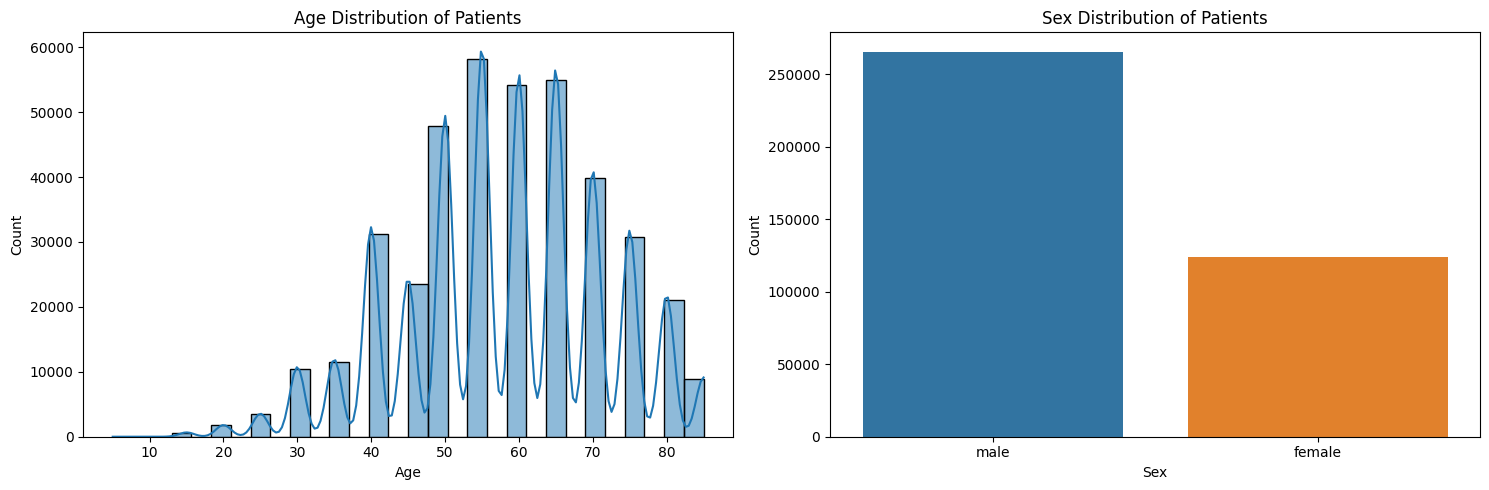

In [9]:
#Visualize
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 5))

# Biểu đồ phân phối tuổi của bệnh nhân
sns.histplot(df['age_approx'].dropna(), bins=30, kde=True, ax=axes1[0])
axes1[0].set_title('Age Distribution of Patients')
axes1[0].set_xlabel('Age')
axes1[0].set_ylabel('Count')

# Biểu đồ tỷ lệ giới tính
sns.countplot(x='sex', data=df, ax=axes1[1])
axes1[1].set_title('Sex Distribution of Patients')
axes1[1].set_xlabel('Sex')
axes1[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

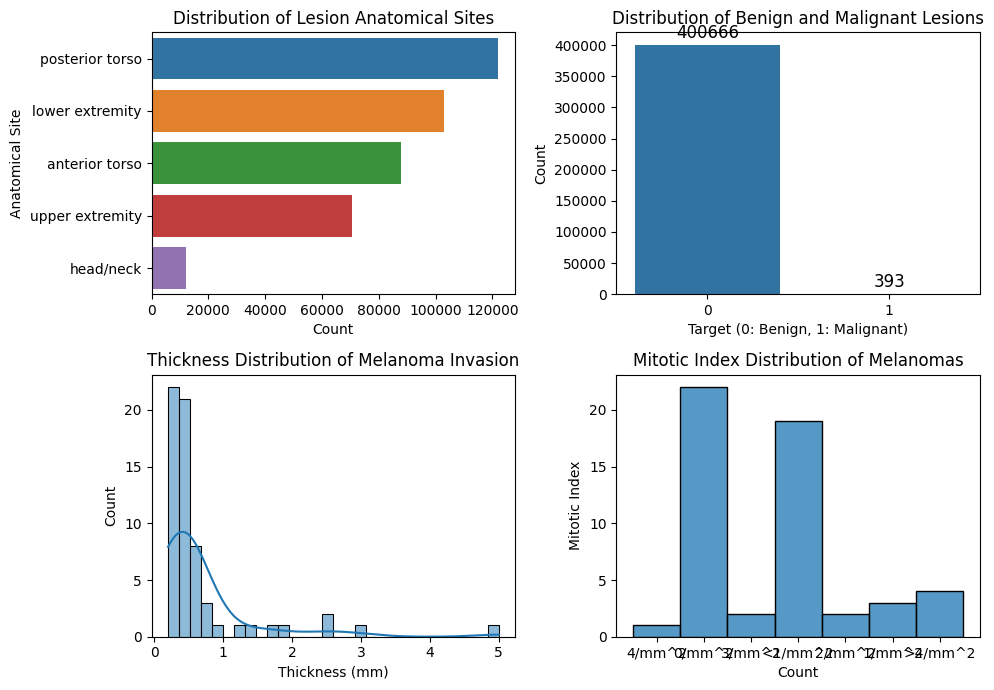

In [10]:
fig2, axes2 = plt.subplots(2, 2, figsize=(10, 7))

# Biểu đồ phân phối vị trí tổn thương
sns.countplot(y='anatom_site_general', data=df, order=df['anatom_site_general'].value_counts().index, ax=axes2[0, 0])
axes2[0, 0].set_title('Distribution of Lesion Anatomical Sites')
axes2[0, 0].set_xlabel('Count')
axes2[0, 0].set_ylabel('Anatomical Site')

# Biểu đồ tỷ lệ benign và malignant
# Vẽ biểu đồ countplot
sns.countplot(x='target', data=df, ax=axes2[0, 1])

# Thiết lập tiêu đề và nhãn trục
axes2[0, 1].set_title('Distribution of Benign and Malignant Lesions')
axes2[0, 1].set_xlabel('Target (0: Benign, 1: Malignant)')
axes2[0, 1].set_ylabel('Count')

# Hiển thị số lượng lên đầu mỗi cột
for p in axes2[0, 1].patches:
    axes2[0, 1].annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', va = 'baseline', 
        fontsize=12, color='black', xytext=(0, 5), 
        textcoords='offset points'
    )
# Biểu đồ phân phối độ dày melanoma
sns.histplot(df['mel_thick_mm'].dropna(), bins=30, kde=True, ax=axes2[1, 0])
axes2[1, 0].set_title('Thickness Distribution of Melanoma Invasion')
axes2[1, 0].set_xlabel('Thickness (mm)')
axes2[1, 0].set_ylabel('Count')

# Biểu đồ phân phối chỉ số phân bào melanoma
sns.histplot(df['mel_mitotic_index'].dropna(), bins=30, ax=axes2[1, 1])
axes2[1, 1].set_title('Mitotic Index Distribution of Melanomas')
axes2[1, 1].set_ylabel('Mitotic Index')
axes2[1, 1].set_xlabel('Count')


# Điều chỉnh layout để các biểu đồ không bị chồng chéo
plt.tight_layout()
plt.show()

# Image processing

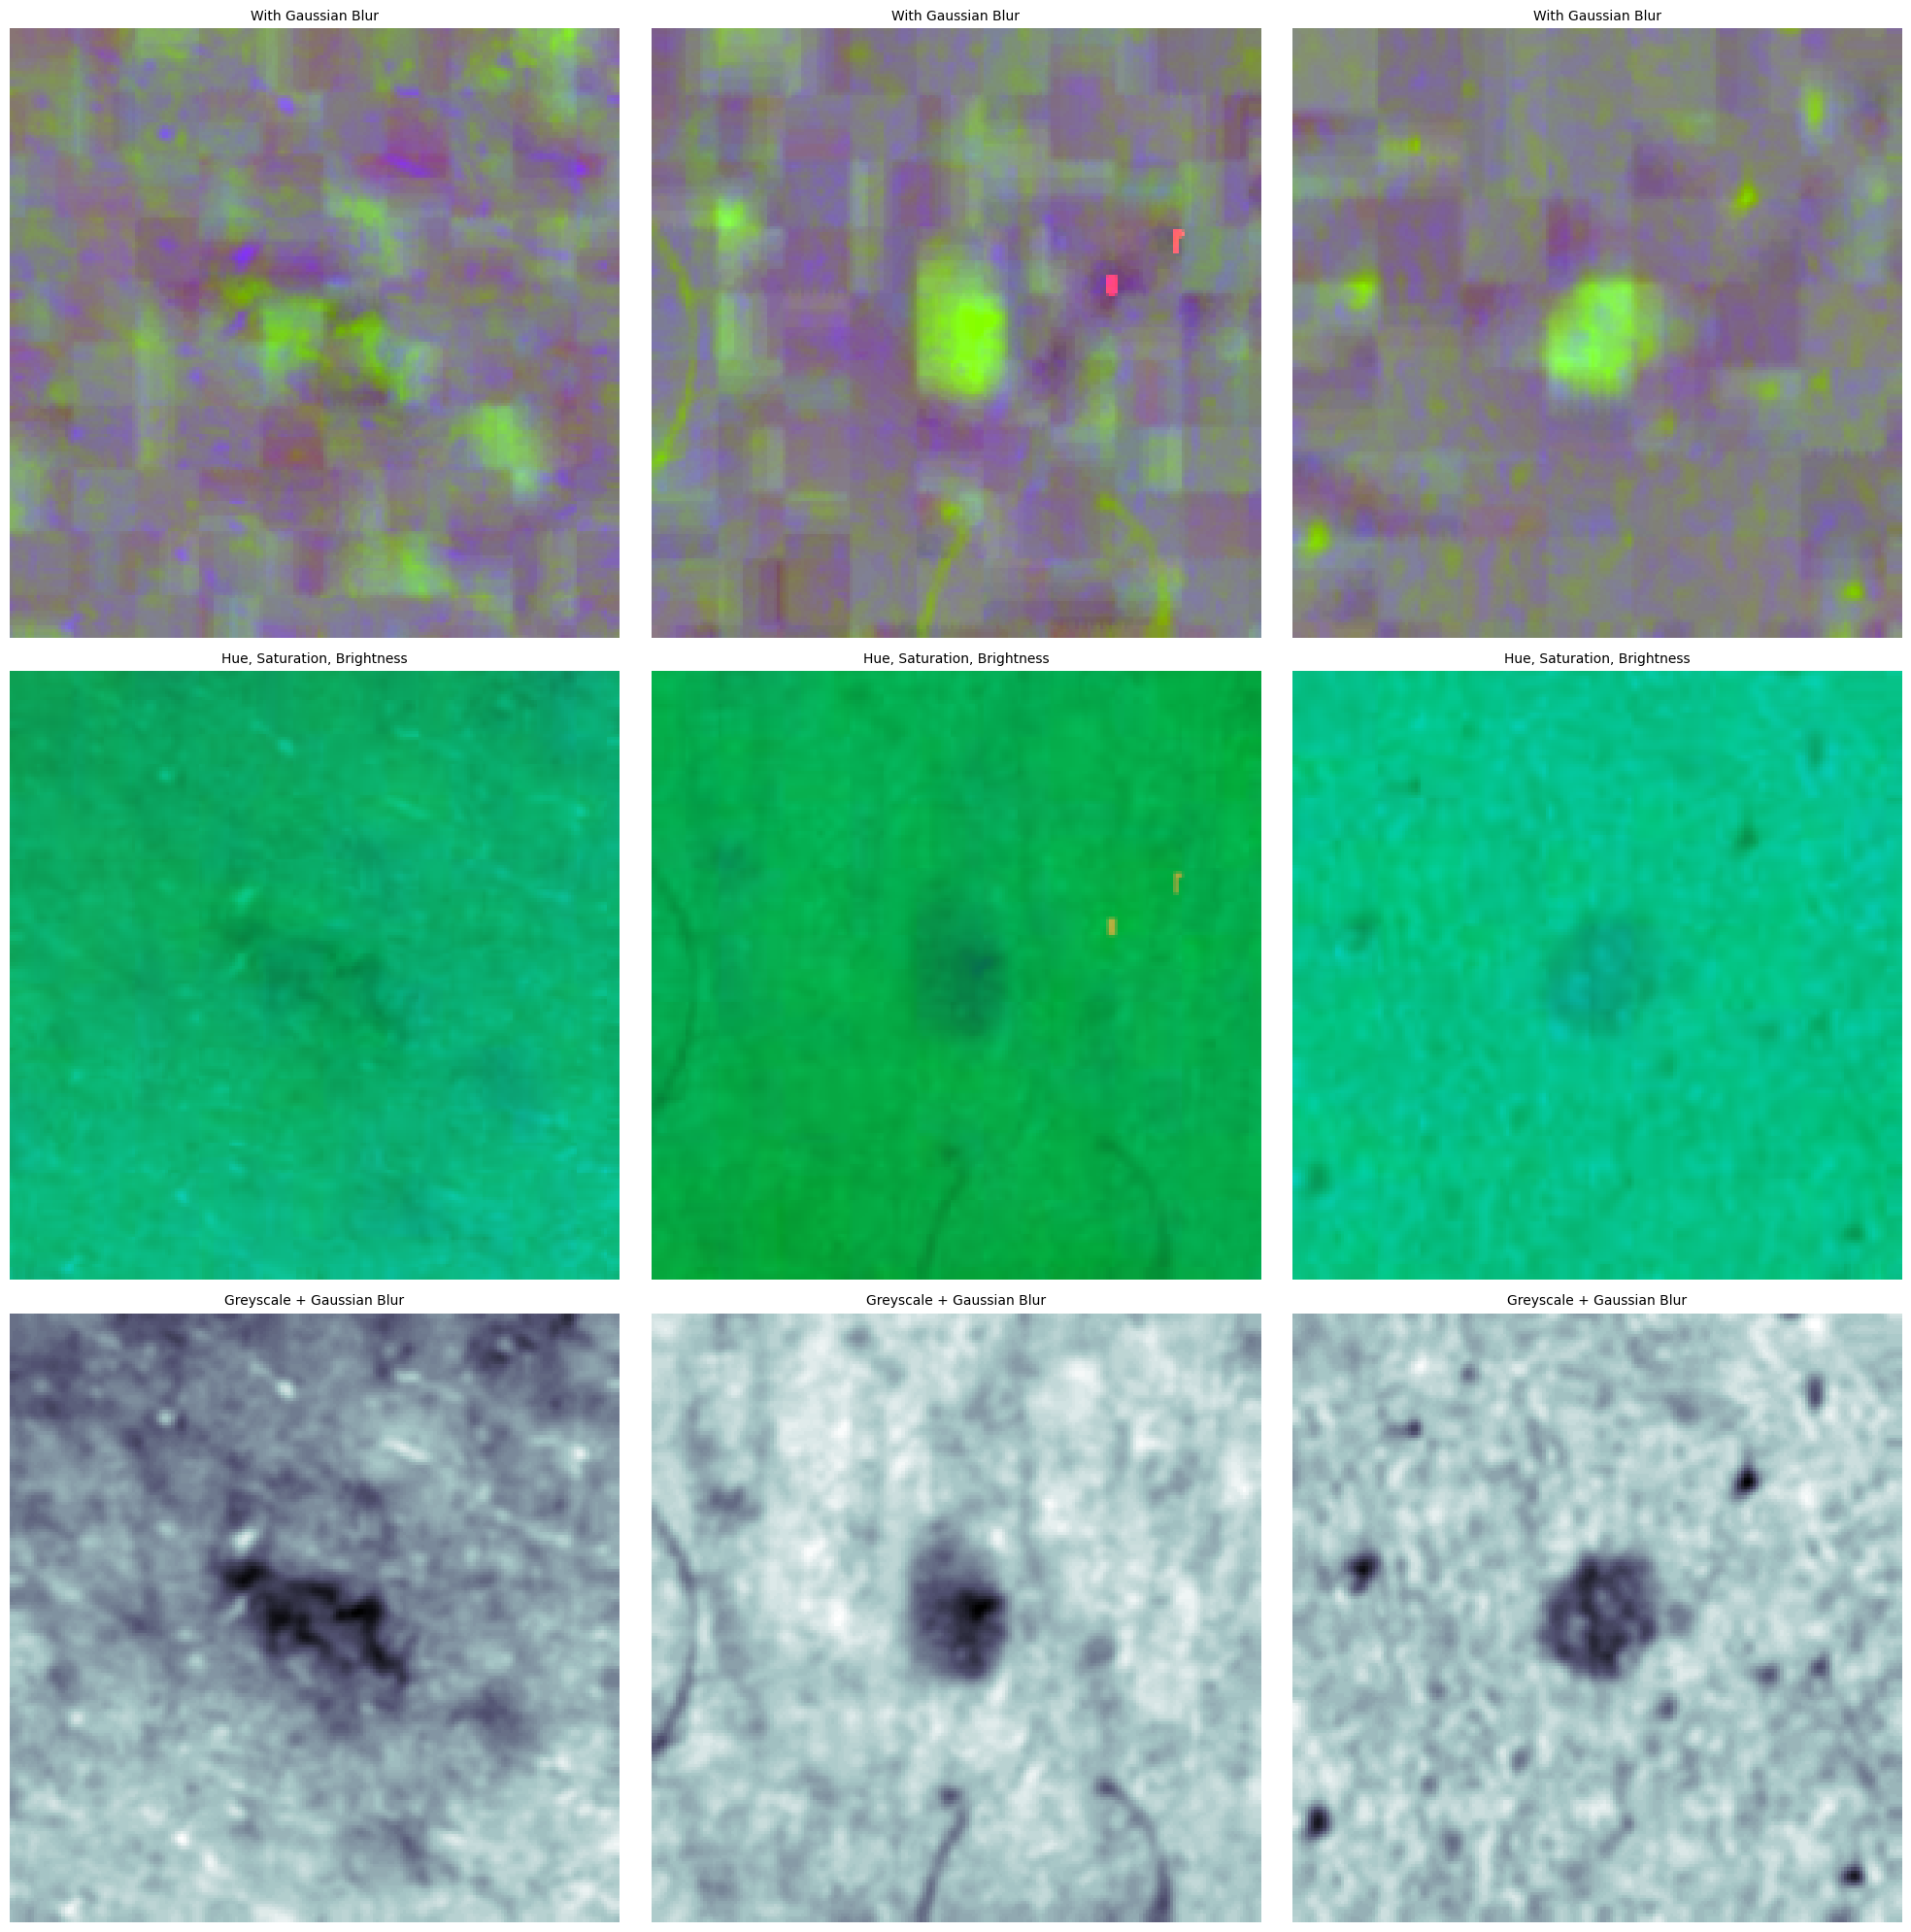

In [11]:
def apply_transformations(image_paths):
    selected_images = np.random.choice(image_paths, 3, replace=False) #choice random 3 images and no replace

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
    methods = [ "With Gaussian Blur", "Hue, Saturation, Brightness", "Greyscale + Gaussian Blur"]
    
    for index, method in enumerate(methods):
        for i, path in enumerate(selected_images):
            image = cv2.imread(path)

            if method == "With Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
                transformed_image = cv2.resize(transformed_image, (200, 200))
                transformed_image = cv2.addWeighted(transformed_image, 4, cv2.GaussianBlur(transformed_image, (0, 0), 256/10), -4, 128)

            elif method == "Hue, Saturation, Brightness":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
                transformed_image = cv2.resize(transformed_image, (200, 200))


            elif method == "Greyscale + Gaussian Blur":
                transformed_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                transformed_image = cv2.resize(transformed_image, (200, 200))
                transformed_image = cv2.GaussianBlur(transformed_image, (5, 5), 0)

            axes[index, i].imshow(transformed_image, cmap=plt.cm.bone if len(transformed_image.shape) == 2 else None)
            axes[index, i].axis('off')
            axes[index, i].set_title(method, fontsize=10)

    plt.tight_layout()
    plt.show()

apply_transformations(path_list)

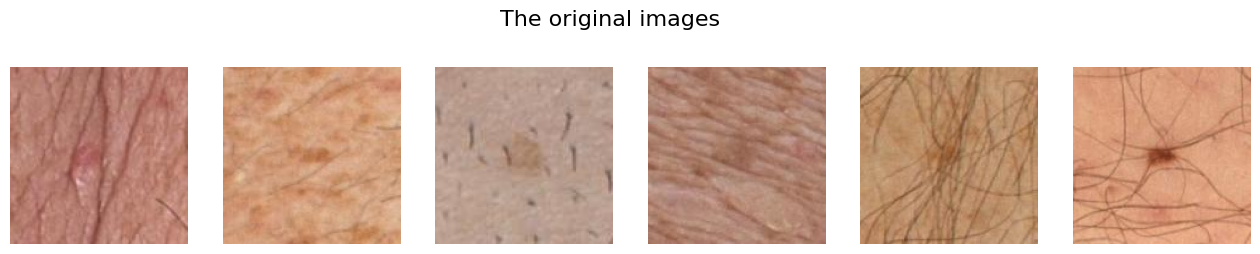

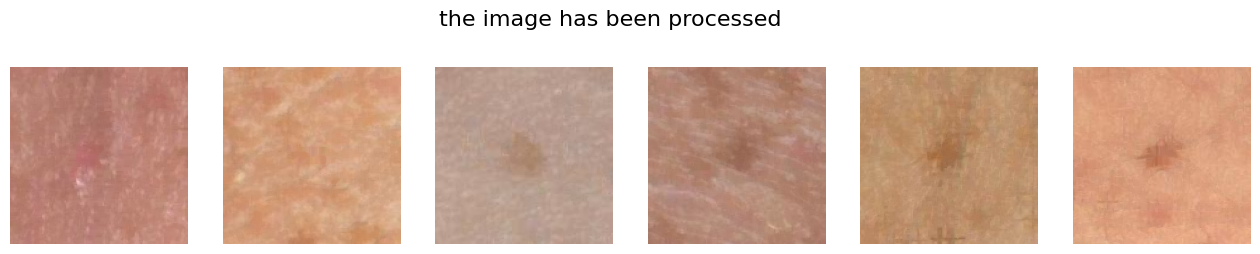

In [12]:
import matplotlib.image as mpimg
# Xử lý tóc cũng như những đường nhăn nheo của da
image_hair = np.array(path_list)[[1, 2, 8, 11, 13, 17]]

def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))

    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image

# Show the Augmented Images
plt.figure(figsize=(16,3))
plt.suptitle("The original images", fontsize = 16)
    
for i, path in enumerate(image_hair):
    image = mpimg.imread(path)
#     image = cv2.resize(image,(300, 300))
        
    plt.subplot(1, 6, i+1)
    plt.imshow(image)
    plt.axis('off')
    
# Show the sample
plt.figure(figsize=(16,3))
plt.suptitle("the image has been processed", fontsize = 16)
    
for i, path in enumerate(image_hair):
    image = mpimg.imread(path)
#     image = cv2.resize(image,(300, 300))
    image = hair_remove(image)
        
    plt.subplot(1, 6, i+1)
    plt.imshow(image)
    plt.axis('off')

In [13]:
def seed_everything(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# Dataset

In [14]:
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class SkinCancerDataset(Dataset):
    def __init__(self, df, transform = None):
        self.df = df.reset_index(drop = True)
        self.path = self.df.iloc[:, 0]
        self.target = self.df.iloc[:, 1]
        self.transform = transform
        
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        img = Image.open(self.path[index])
        img = transform(img)
        target = self.target[index]
        
        return img, target


# df["path_list"] = pd.Series(path_list)
melanoma = df[df["target"] == 1]
nonmelanoma = df[df["target"] == 0].sample(len(melanoma) * 3)

Data = pd.concat([melanoma, nonmelanoma], axis = 0).reset_index(drop = True)
df = Data[["path_list", "target"]]Split Train, Valid, Test

In [15]:
df["path_list"] = pd.Series(path_list)
melanoma = df[df["target"] == 1]
nonmelanoma = df[df["target"] == 0].sample(len(melanoma) * 3)

Data = pd.concat([melanoma, nonmelanoma], axis = 0).reset_index(drop = True)
df = Data[["path_list", "target"]]

In [16]:
df['target'].value_counts()

target
0    1179
1     393
Name: count, dtype: int64

In [17]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df.iloc[:, 1] = label_encoder.fit_transform(df.iloc[:, 1])

#chia df thành train và test sau đó chia tập train thành train và valid
Train, Test = tts(df, test_size = 0.01/2, stratify = df.iloc[:, 1])
Train, Valid = tts(Train, test_size = 0.1, stratify = Train.iloc[:, 1])

print(f"Train Shape is: {Train.shape}")
print(f"Valid Shape is: {Valid.shape}")
print(f"Test Shape is: {Test.shape}")

print(f"Validation and Test Len is {(Valid.shape[0]  + Test.shape[0]) / df.shape[0] :.2%}")

train_ds = SkinCancerDataset(Train, transform)
valid_ds = SkinCancerDataset(Valid, transform_test)
test_ds = SkinCancerDataset(Test, transform_test)

train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 32, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = 32, shuffle = False)

Train Shape is: (1407, 2)
Valid Shape is: (157, 2)
Test Shape is: (8, 2)
Validation and Test Len is 10.50%


# Confussion matrix

In [18]:
#Confussion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, device, dataset_type):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device).float()
            labels = labels.to(device).long()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{dataset_type} Confusion Matrix')
    plt.show()
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Calculate specificity for each class
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    specificity = tn / (tn + fp)
    
    # Print evaluation metrics
    print(f'{dataset_type} Accuracy: {accuracy:.4f}')
    print(f'{dataset_type} Precision: {precision:.4f}')
    print(f'{dataset_type} Recall (Sensitivity): {recall:.4f}')
    print(f'{dataset_type} F1 Score: {f1:.4f}')
    print(f'{dataset_type} Specificity: {specificity:.4f}')

    
# Accuracy: Tỷ lệ dự đoán đúng trên tổng số dự đoán.
# Precision: Tỷ lệ dự đoán dương đúng trên tổng số dự đoán dương.
# Recall (Sensitivity): Tỷ lệ dự đoán dương đúng trên tổng số mẫu thực sự dương.
# F1 Score: Trung bình điều hòa của Precision và Recall.
# Specificity: Tỷ lệ dự đoán âm đúng trên tổng số mẫu thực sự âm.

# ROC

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def compute_roc_auc(model, dataloader, device):
    model.eval()
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device).float()
            targets = targets.to(device).long()
            
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.append(probs[:, 1].cpu().numpy())  # Xác suất lớp 1
            all_targets.append(targets.cpu().numpy())

    all_targets = np.concatenate(all_targets)
    all_probs = np.concatenate(all_probs)

    # Tính TPR và FPR
    fpr, tpr, _ = roc_curve(all_targets, all_probs)
    
    # Tính AUC
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Train

In [20]:
def train(model, optimizer, criterion, train_dl, valid_dl, epochs):
    result = []
    val_res = []

    for e in range(epochs):
        print(f"Training the Epoch: {e + 1}")
        model.train()
        total_loss = 0
        total = 0
        correct = 0
        
        for X_train, y_train in train_dl:
            X_train, y_train = X_train.to(device).float(), y_train.to(device).long()
            
            y_pred = model(X_train)
            if isinstance(y_pred, tuple):  # In case of Inception
                y_pred = y_pred[0]
                
            loss = criterion(y_pred, y_train)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y_train.size(0)
            correct += (predicted == y_train).sum().item()
            
        acc_train = 100 * correct / total
        _, val_acc = valid(model, valid_dl, device)
        
        print(f'Epoch: [{e+1}/{epochs}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {val_acc:.2f}')
        result.append(acc_train)
        val_res.append(val_acc)
    
    # Save results to files
    np.savetxt('result.csv', np.array(result), fmt='%.2f', delimiter=',')
    np.savetxt('val_result.csv', np.array(val_res), fmt='%.2f', delimiter=',')  
    
    evaluate_model(model, train_dl, device, 'Train')
    evaluate_model(model, valid_dl, device, 'Validation')
    evaluate_model(model, test_dl, device, 'Test')
    
    # Save the model
    if isinstance(Model, type(models.efficientnet_b0())):
        torch.save(Model.state_dict(), 'efficientnet_b0_skin_cancer_model.pth')
    
# Validation Function
def valid(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sample, target in val_loader:
            sample = sample.to(device).float()
            target = target.to(device).long()
            outputs = model(sample)
            _, predicted = torch.max(outputs.data, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_accuracy = 100 * correct / total
    return [], val_accuracy


In [21]:
# Normalized values are commonly used for RGB images in PyTorch
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(image, mean, std):
    image = image.clone()  # Crear una copia para no modificar el original
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # Desnormalizar
    return image

def preds(Model):
    images, targets = next(iter(test_dl))  
    indices = np.arange(len(images))
    np.random.shuffle(indices)

    fig, axes = plt.subplots(8, 2, figsize=(15, 24)) 
    axes = axes.ravel()

    int_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}

    for i in range(min(len(indices), len(axes) // 2)):
        idx = indices[i]
        image, actual_target = images[idx], targets[idx]
        image_tensor = image.to(device).unsqueeze(0)
        output = Model(image_tensor)
        _, prediction = torch.max(output, 1)

        predicted_label = int_to_label[prediction.cpu().item()] 
        actual_label = int_to_label[actual_target.item()]

        image = denormalize(image, mean, std)
        image = image.permute(1, 2, 0)  
        image = image.cpu().numpy()

        axes[2 * i].imshow(image)
        axes[2 * i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        axes[2 * i].axis('off')

        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy().flatten()
        
        # Vẽ biểu đồ thanh và lưu trữ các đối tượng thanh
        bars = axes[2 * i + 1].bar(int_to_label.values(), probabilities)
        axes[2 * i + 1].set_ylim(0, 1)
        axes[2 * i + 1].set_title("Probabilities")

        # Thêm nhãn xác suất lên đầu mỗi cột
        for bar in bars:
            yval = bar.get_height()
            axes[2 * i + 1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', 
                                 ha='center', va='bottom', fontsize=10, color='black')

    plt.tight_layout()
    plt.show()


# Load pretrained

In [22]:
from torchvision.models import efficientnet_b0
EfficientNet = efficientnet_b0(pretrained=True)
VGG = models.vgg19(pretrained = True)
Alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 152MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 162MB/s]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 156MB/s]


# VGG19 with Pytorch

Training the Epoch: 1
Epoch: [1/20], Loss: 0.0186, Train Acc: 73.13, Val Acc: 75.16
Training the Epoch: 2
Epoch: [2/20], Loss: 0.0157, Train Acc: 76.83, Val Acc: 77.71
Training the Epoch: 3
Epoch: [3/20], Loss: 0.0131, Train Acc: 81.59, Val Acc: 79.62
Training the Epoch: 4
Epoch: [4/20], Loss: 0.0125, Train Acc: 83.08, Val Acc: 80.25
Training the Epoch: 5
Epoch: [5/20], Loss: 0.0115, Train Acc: 84.79, Val Acc: 74.52
Training the Epoch: 6
Epoch: [6/20], Loss: 0.0106, Train Acc: 85.50, Val Acc: 78.34
Training the Epoch: 7
Epoch: [7/20], Loss: 0.0096, Train Acc: 87.56, Val Acc: 78.98
Training the Epoch: 8
Epoch: [8/20], Loss: 0.0083, Train Acc: 89.77, Val Acc: 82.17
Training the Epoch: 9
Epoch: [9/20], Loss: 0.0072, Train Acc: 89.91, Val Acc: 78.34
Training the Epoch: 10
Epoch: [10/20], Loss: 0.0112, Train Acc: 85.22, Val Acc: 80.89
Training the Epoch: 11
Epoch: [11/20], Loss: 0.0081, Train Acc: 89.34, Val Acc: 80.25
Training the Epoch: 12
Epoch: [12/20], Loss: 0.0064, Train Acc: 92.25, V

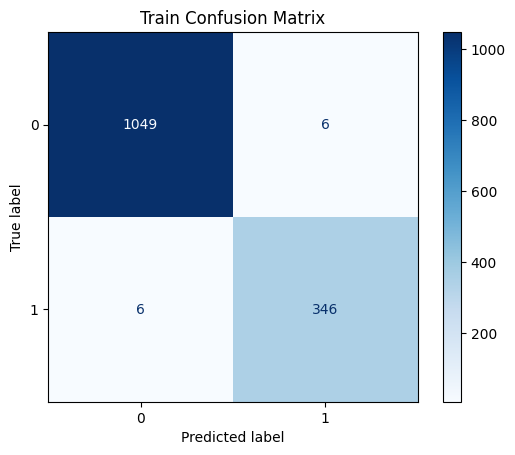

Train Accuracy: 0.9915
Train Precision: 0.9915
Train Recall (Sensitivity): 0.9915
Train F1 Score: 0.9915
Train Specificity: 0.9943


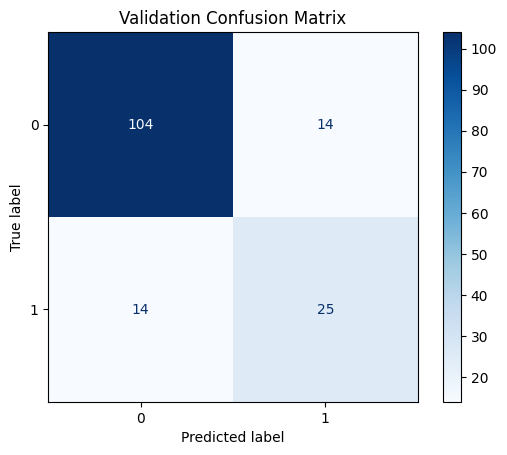

Validation Accuracy: 0.8217
Validation Precision: 0.8217
Validation Recall (Sensitivity): 0.8217
Validation F1 Score: 0.8217
Validation Specificity: 0.8814


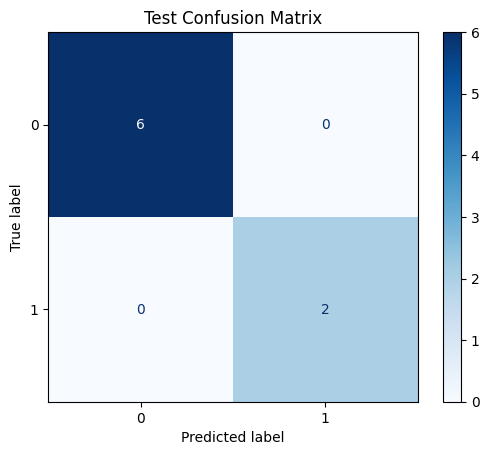

Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall (Sensitivity): 1.0000
Test F1 Score: 1.0000
Test Specificity: 1.0000


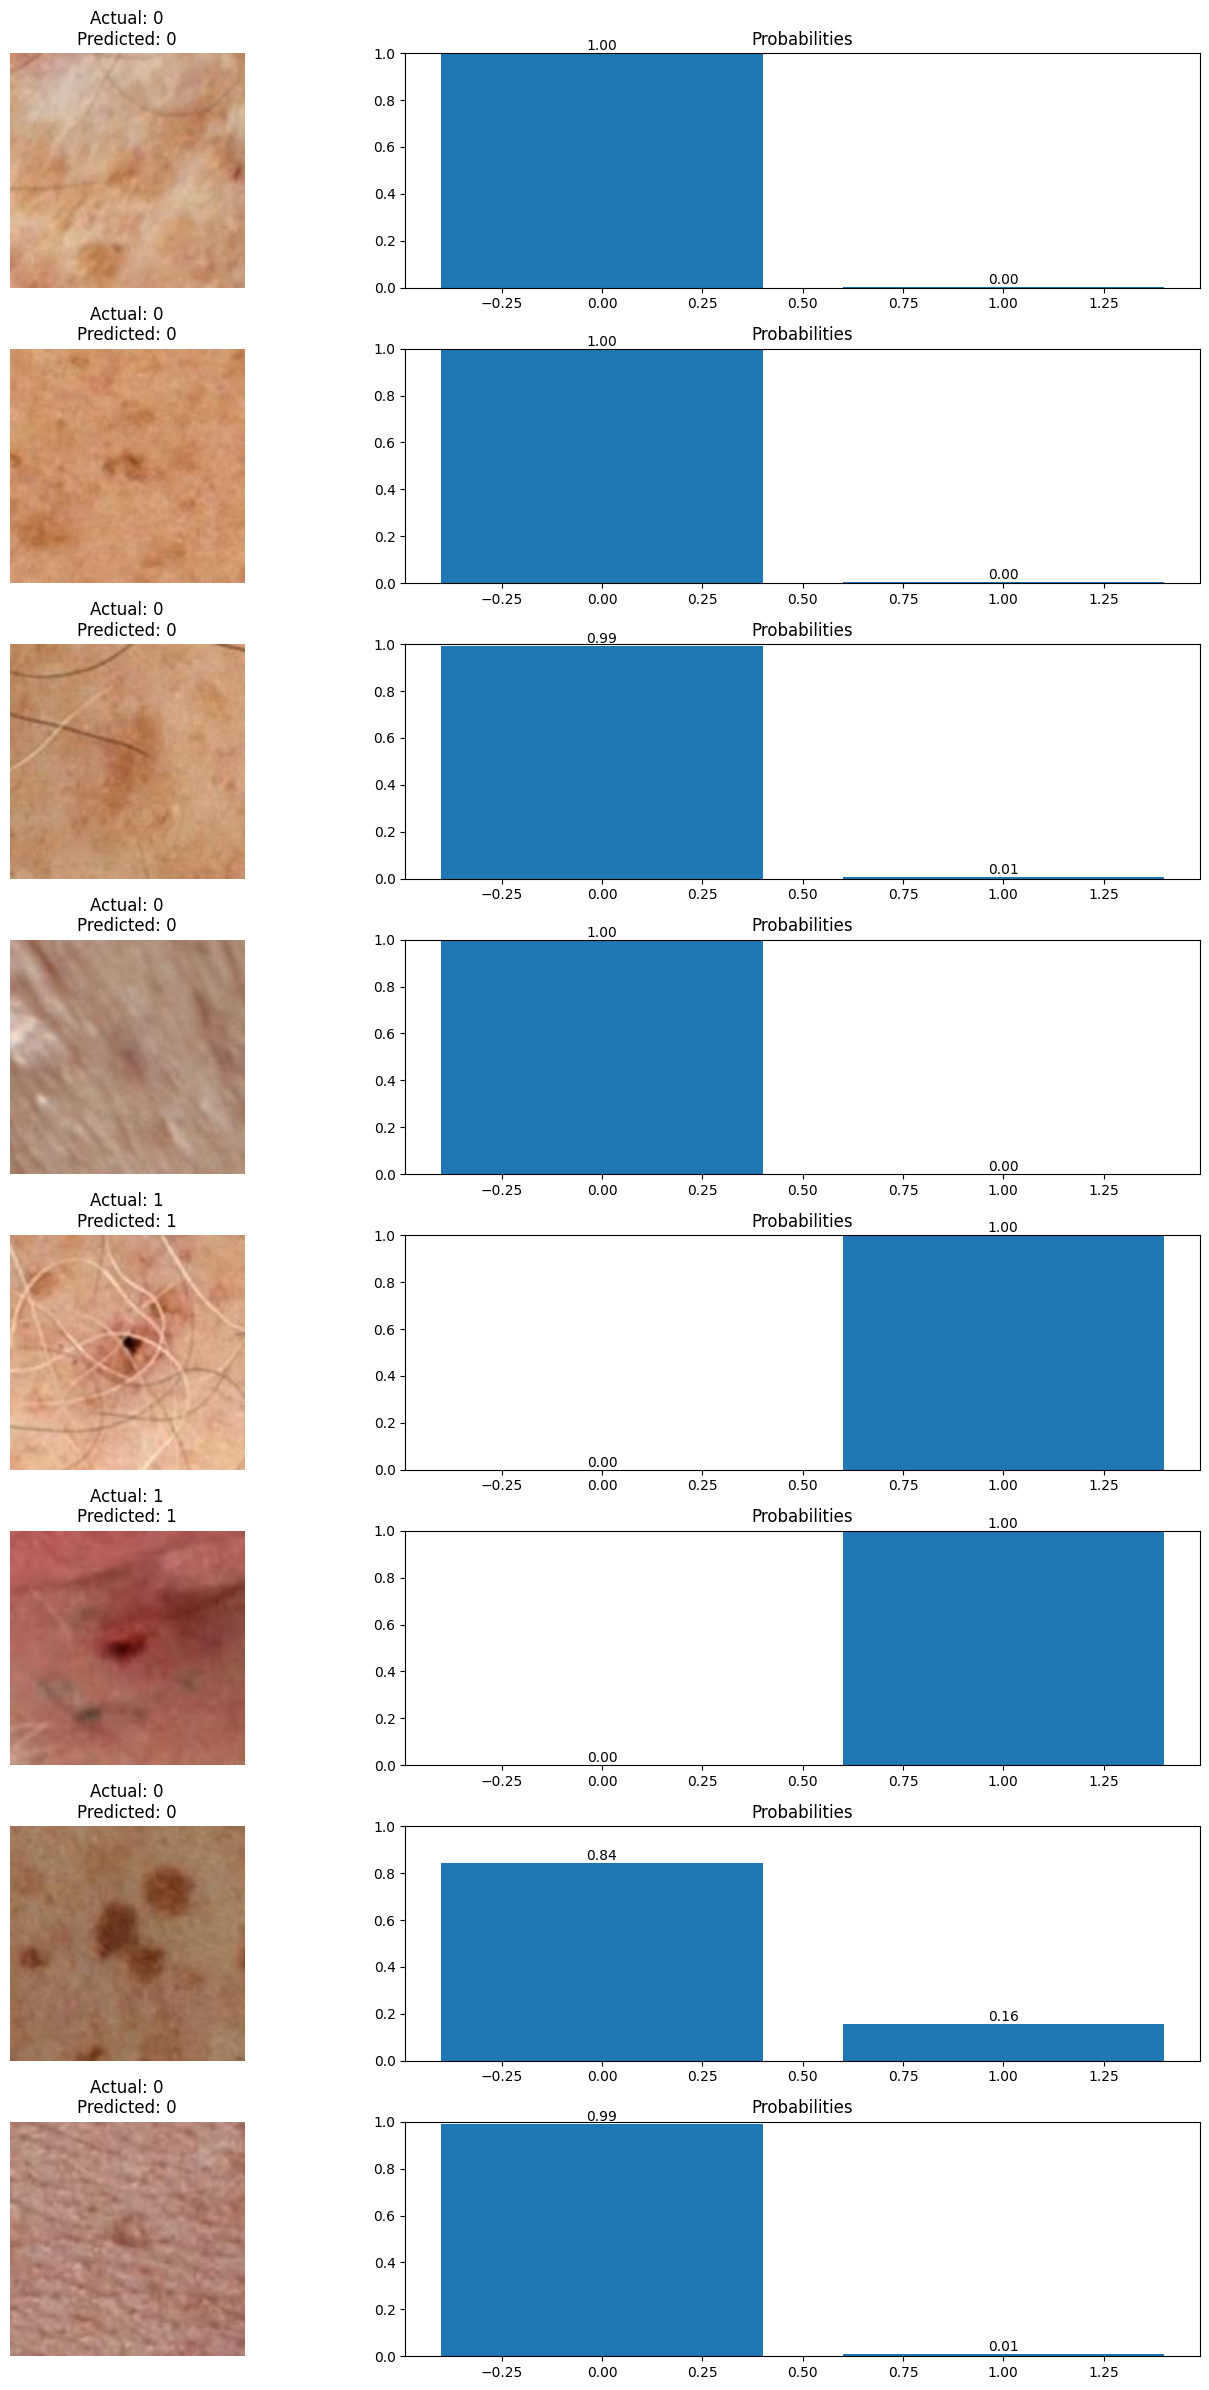

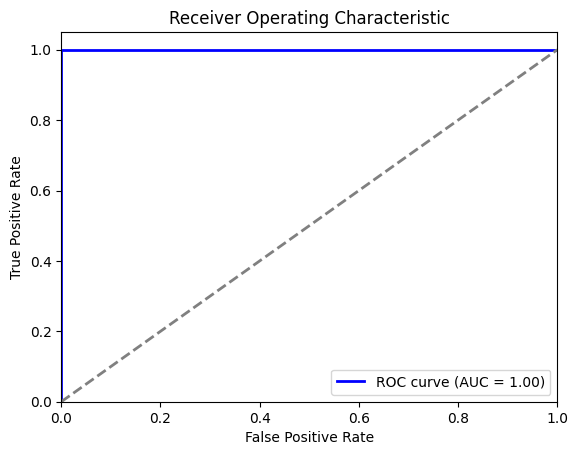

Model is good with AUC = 1.00


In [23]:
for param in Alexnet.parameters():
    param.requires_grad = False
    
features = VGG.classifier[6].in_features 
VGG.classifier[6] = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Model = VGG.to(device)



optimizer = optim.SGD(Model.parameters(), lr = 0.003, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

train(Model, optimizer, criterion, train_dl, valid_dl, 20)
# plot()
preds(Model)

# Tính ROC và AUC trên tập validation hoặc test
fpr, tpr, roc_auc = compute_roc_auc(Model, test_dl, device)

# Hiển thị ROC curve và giá trị AUC
plot_roc_curve(fpr, tpr, roc_auc)

# Đánh giá mô hình dựa trên AUC
if roc_auc >= 0.8:
    print(f'Model is good with AUC = {roc_auc:.2f}')
else:
    print(f'Model is not good with AUC = {roc_auc:.2f}')

# Efficient Net

Training the Epoch: 1
Epoch: [1/20], Loss: 0.0153, Train Acc: 78.96, Val Acc: 71.97
Training the Epoch: 2
Epoch: [2/20], Loss: 0.0129, Train Acc: 82.44, Val Acc: 80.25
Training the Epoch: 3
Epoch: [3/20], Loss: 0.0109, Train Acc: 84.08, Val Acc: 80.89
Training the Epoch: 4
Epoch: [4/20], Loss: 0.0099, Train Acc: 87.78, Val Acc: 79.62
Training the Epoch: 5
Epoch: [5/20], Loss: 0.0096, Train Acc: 86.92, Val Acc: 86.62
Training the Epoch: 6
Epoch: [6/20], Loss: 0.0086, Train Acc: 88.34, Val Acc: 80.25
Training the Epoch: 7
Epoch: [7/20], Loss: 0.0080, Train Acc: 89.62, Val Acc: 84.71
Training the Epoch: 8
Epoch: [8/20], Loss: 0.0080, Train Acc: 89.41, Val Acc: 83.44
Training the Epoch: 9
Epoch: [9/20], Loss: 0.0064, Train Acc: 91.54, Val Acc: 79.62
Training the Epoch: 10
Epoch: [10/20], Loss: 0.0075, Train Acc: 90.62, Val Acc: 78.34
Training the Epoch: 11
Epoch: [11/20], Loss: 0.0068, Train Acc: 90.83, Val Acc: 84.08
Training the Epoch: 12
Epoch: [12/20], Loss: 0.0052, Train Acc: 93.46, V

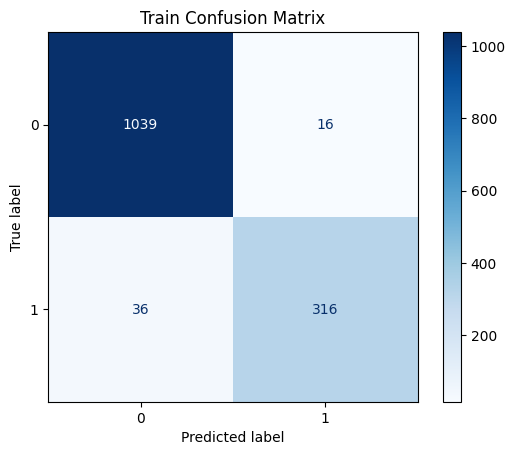

Train Accuracy: 0.9630
Train Precision: 0.9628
Train Recall (Sensitivity): 0.9630
Train F1 Score: 0.9627
Train Specificity: 0.9848


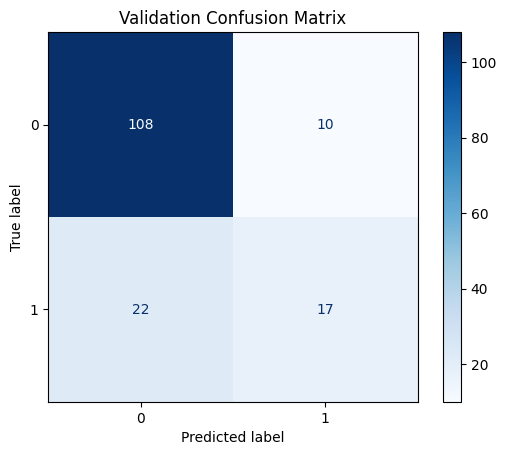

Validation Accuracy: 0.7962
Validation Precision: 0.7808
Validation Recall (Sensitivity): 0.7962
Validation F1 Score: 0.7826
Validation Specificity: 0.9153


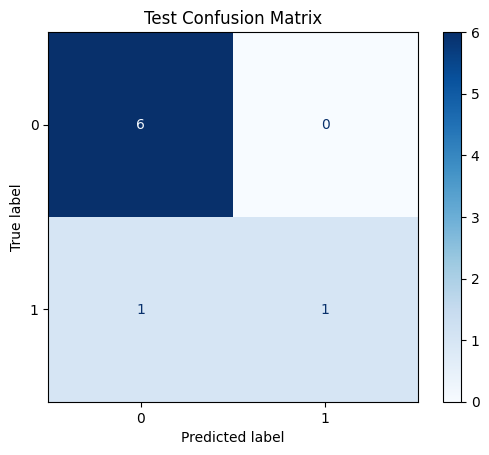

Test Accuracy: 0.8750
Test Precision: 0.8929
Test Recall (Sensitivity): 0.8750
Test F1 Score: 0.8590
Test Specificity: 1.0000


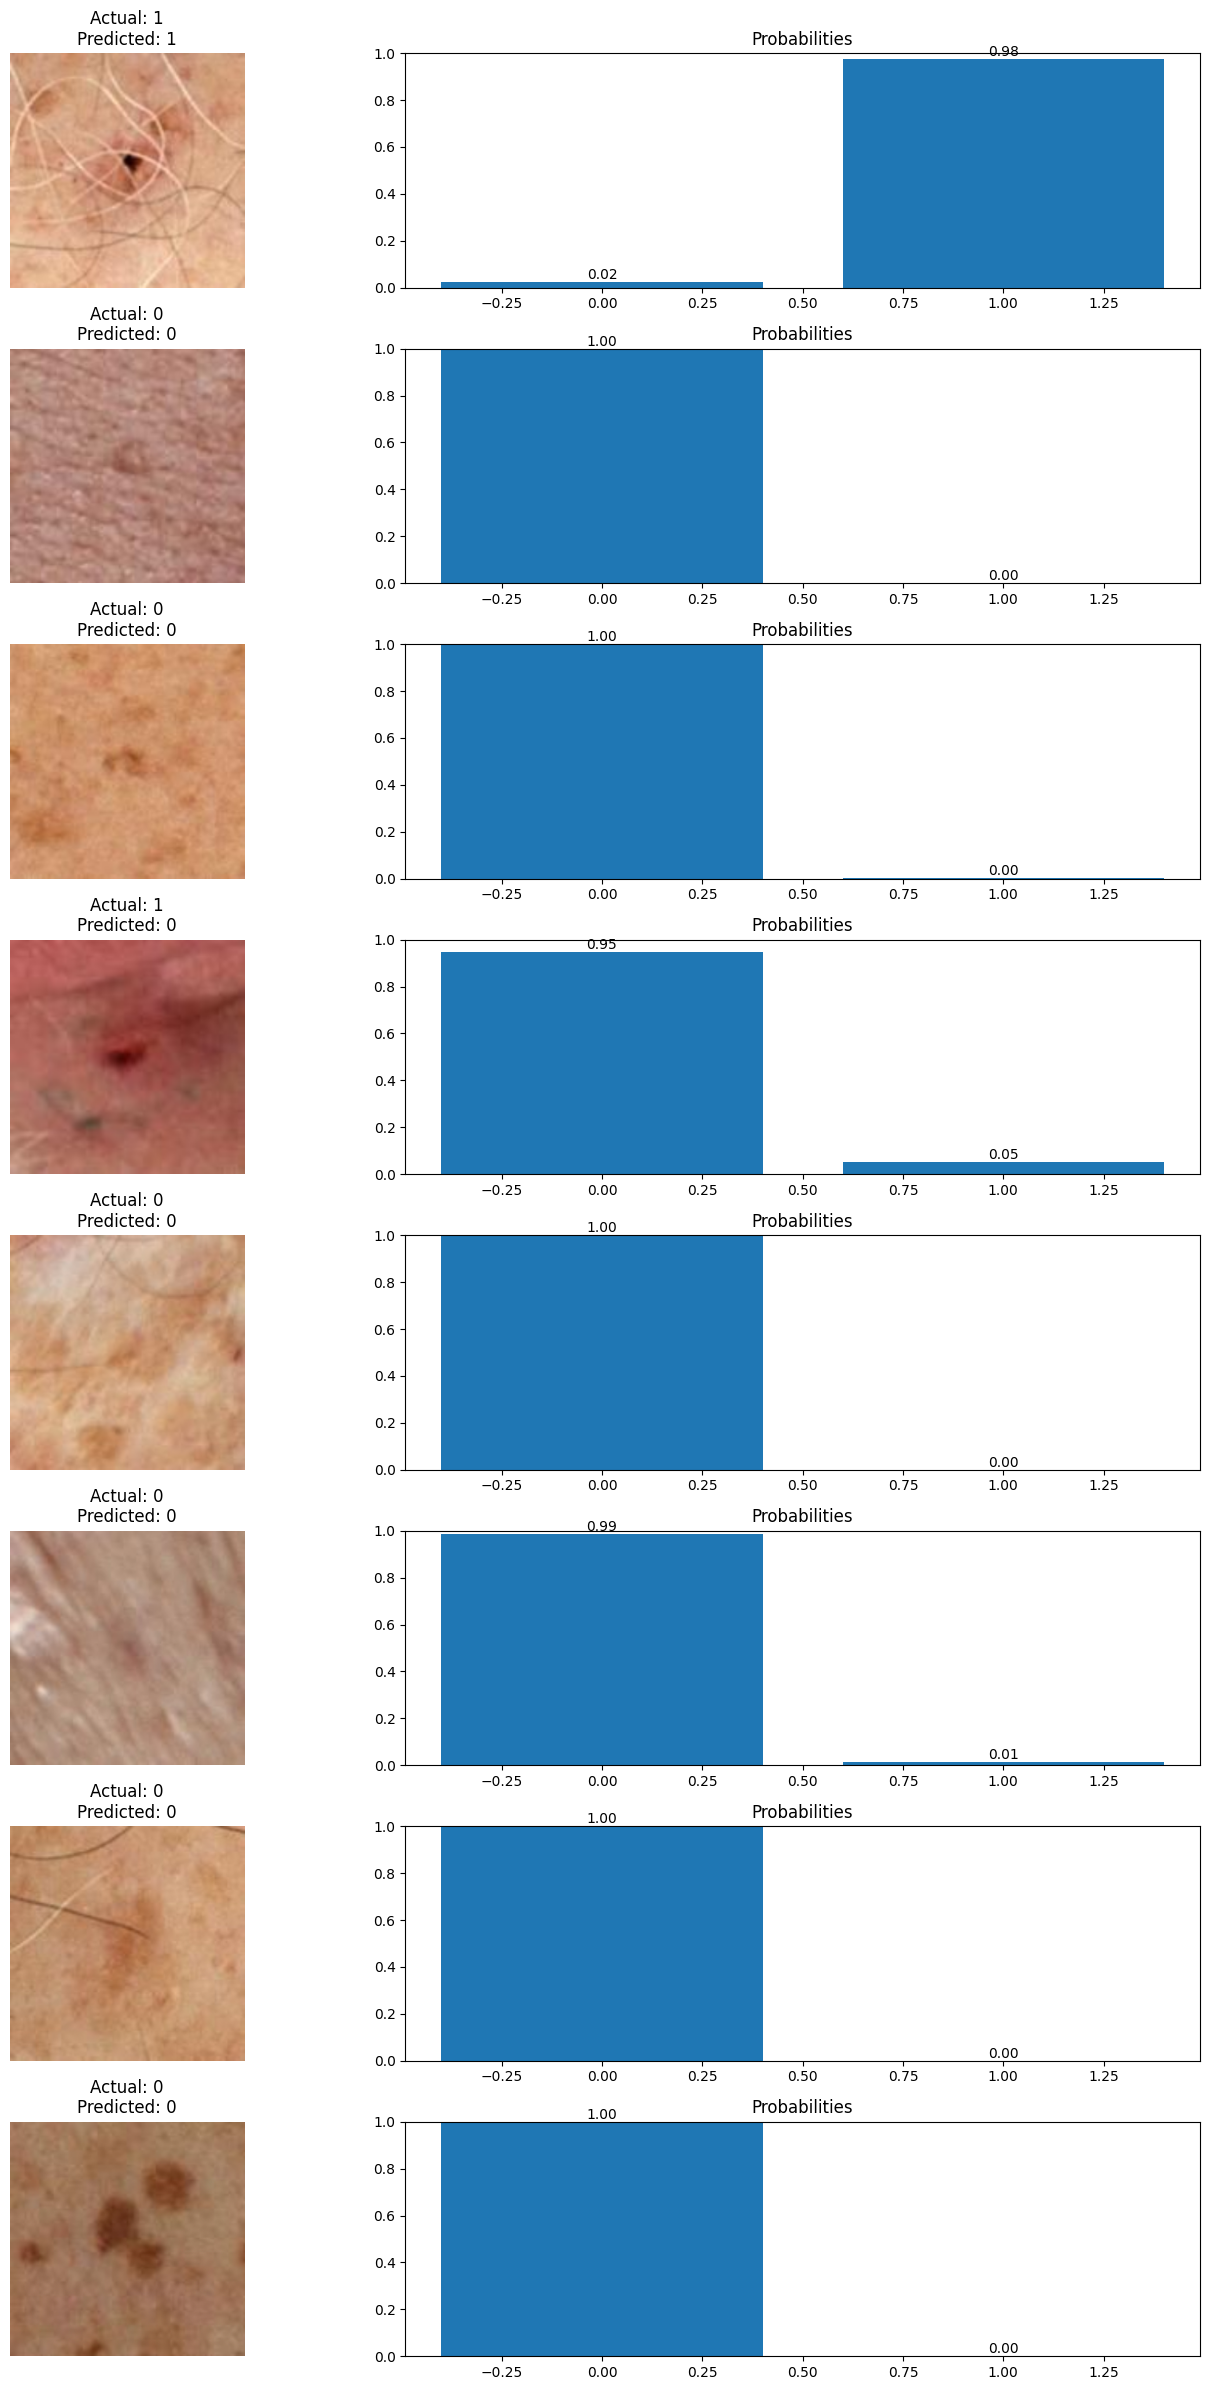

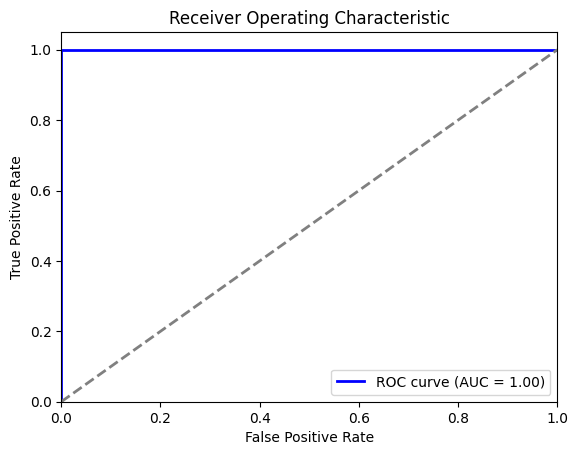

Model is good with AUC = 1.00


In [24]:
for param in VGG.parameters():
    param.requires_grad = False

features = EfficientNet.classifier[1].in_features 
EfficientNet.classifier[1] = nn.Linear(features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Model = EfficientNet.to(device)

optimizer = optim.Adam(Model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

train(Model, optimizer, criterion, train_dl, valid_dl, 20)
# plot()
preds(Model)

# Tính ROC và AUC trên tập validation hoặc test
fpr, tpr, roc_auc = compute_roc_auc(Model, test_dl, device)

# Hiển thị ROC curve và giá trị AUC
plot_roc_curve(fpr, tpr, roc_auc)

# Đánh giá mô hình dựa trên AUC
if roc_auc >= 0.8:
    print(f'Model is good with AUC = {roc_auc:.2f}')
else:
    print(f'Model is not good with AUC = {roc_auc:.2f}')